In this notebook we are going to do the following tasks:

*     Data preperation and exploration
*     Compare the effectiveness of different machine learning models on this data



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/kaggle/input/co2-emission-by-vehicles/CO2 Emissions_Canada.csv")

In [ ]:
data.head()

How is the Fuel Consumption Comb (L/100 km) calculated?

In [ ]:
v1 = data['Fuel Consumption City (L/100 km)']
v2 = data['Fuel Consumption Hwy (L/100 km)']
v3 = data['Fuel Consumption Comb (L/100 km)']
A = np.column_stack([v1, v2])
x = np.linalg.lstsq(A, v3)
print(x[0])

In [ ]:
avg = np.round(np.average([data['Fuel Consumption City (L/100 km)'],data['Fuel Consumption Hwy (L/100 km)']], weights=x[0], axis=0),1)
print('avg formula ' ,avg[:5], ' == ', 'Fuel Consumption Comb ', list(data['Fuel Consumption Comb (L/100 km)'].iloc[:5]))
difference = np.abs(data['Fuel Consumption Comb (L/100 km)']-avg)
print('The average difference is: ',np.round(np.average(difference),3),'(L/100 km)')
print('The max difference is: ',np.max(difference),'(L/100 km)')

looking for null's:

In [ ]:
data.isnull().sum()

### **Great!** there are no null's in the dataset.
## 'describe' is a great function for looking at your data and gaining good intuition.

In [ ]:
data.describe()

In [ ]:
data.describe(include=['O'])

Some conclusions drom these describe tables are:


*   we have 7385 vehicle's in total
*   the mean and the median of CO2 is around 250

*   **Fuel Consumption City** is higer then **Fuel Consumption Hwy** in all parametes
*   most of the unique values	have less then 50 items, Model has more than 2000 items when the most common one (F-150 FFV 4X4) shown 32 times (1.5%)

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),cmap="BrBG",annot=True)

## **What can we learn from the correlation table?**


*   all features have a strong positive correlation with CO2 Emissions except FCC(mpg) that has a strong negative correlation with CO2 Emissions
*   there is a storng correlation between the size of the engine and the number of cilinders


### **How does the data look like?**

In [ ]:
cat_data = data.select_dtypes(exclude=['float64', 'int64'])
col = cat_data.columns
col = col.drop('Model')#more than 2000 different items..  
for feature in col:
  sns.catplot(x=feature, y="CO2 Emissions(g/km)", data=data, aspect=7)


We can learn from this that van's have more CO2 emissions

In [ ]:
num_data = data.select_dtypes(include=['float64', 'int64'])
num_data = num_data.drop("CO2 Emissions(g/km)", axis =1)
col = num_data.columns
n_un = num_data.nunique()

for id, feature in enumerate(col):
  if n_un[id] <30:
    sns.catplot(x=feature, y="CO2 Emissions(g/km)", data=data)
  else:
    sns.relplot(x=feature, y='CO2 Emissions(g/km)', data= data)

The data fits our correlation from before.

When the parmater rises the CO2 rises as well.

# **Now is the intresting part.**
I looked again at the plot from the Fuel Consumption and saw that there are two different distributions.

and i asked myself why is this happening.


In [ ]:
sns.relplot(x='Fuel Consumption Hwy (L/100 km)', y='CO2 Emissions(g/km)', data= data)

so.. i looked at a the specific part of the data that had the different distrebutions and tried to look for the responsible features.

In [ ]:
new_data = data.loc[data['Fuel Consumption Hwy (L/100 km)']<20]

new_data = new_data.loc[new_data['Fuel Consumption Hwy (L/100 km)']>9]

s = new_data.sort_values(by= 'CO2 Emissions(g/km)', ignore_index=True)

feature_to_compare = ['Make', 'Vehicle Class', 'Fuel Type', 'Engine Size(L)', 'Cylinders', 'Transmission']

sns.relplot(x='Fuel Consumption Hwy (L/100 km)', y='CO2 Emissions(g/km)', data= new_data)

for f in feature_to_compare:
  sns.catplot(x=f, y="CO2 Emissions(g/km)", data=s, height=3, aspect=11)

I cant see anything suspicious... and you?

So i looked even closer and **this is what i found**:

In [ ]:
from sklearn.cluster import KMeans
def FuelType_vs_FuelConsumption(data, fc = 'Hwy'):
  feature_dict = {'Hwy': ['Fuel Consumption Hwy (L/100 km)',11], #11 is the starting point i chose for looking at the graph.
             'City': ['Fuel Consumption City (L/100 km)', 14], #14 is the starting point i chose for looking at the graph.
             'Comb': ['Fuel Consumption Comb (L/100 km)', np.round(14*0.54977202+11*0.45035134)]} 
  feature, start = feature_dict[fc]
  centers = []
  centers2 = []
  centers3 = []
  data_to_plot_dict = {}
  data_for_fuel_plot_dict = {}
  for i in range (6):
    spec_data = data.loc[data[feature]<start+1+i]
    spec_data = spec_data.loc[spec_data[feature]>start+i]
    data_for_fuel_plot_dict[i] = spec_data
    cols = spec_data.columns
    cols = cols.drop(feature)
    cols = cols.drop('CO2 Emissions(g/km)')
    train_data = spec_data.drop(cols, axis=1)
    spec_data_copy = train_data.copy()
    train_data = train_data.values
    neigh = KMeans(n_clusters=2, random_state=42).fit(train_data)
    labels = neigh.labels_
    centers.append(neigh.cluster_centers_)
    tt = spec_data.loc[spec_data['Fuel Type'] == 'E']
    centers2.append(np.average(tt['CO2 Emissions(g/km)']))
    tt = spec_data.loc[spec_data['Fuel Type'] != 'E']
    centers3.append(np.average(tt['CO2 Emissions(g/km)']))
    spec_data_copy['label'] = labels
    data_to_plot_dict[i] = spec_data_copy
 
 
  f, ax = plt.subplots(2, 6, figsize=[40,10])
  for i in range(len(data_to_plot_dict)):
    center_high_fc = np.round(centers[i][0][1])
    center_low_fc = np.round(centers[i][1][1])
    center_high_ft = np.round(centers3[i])
    center_low_ft = np.round(centers2[i])
    p = data_to_plot_dict[i]
    spec_data = data_for_fuel_plot_dict[i]
    ax[0,i].set_title('centers '+str(center_high_fc)+' / '+str(center_low_fc))
    ax[1,i].set_title('centers '+str(center_high_ft)+' / '+str(center_low_ft))
    sns.swarmplot(x=feature, y='CO2 Emissions(g/km)', hue='label', data=p, ax=ax[0,i])
    sns.boxplot(x='Fuel Type', y="CO2 Emissions(g/km)", data=spec_data.sort_values(by= 'CO2 Emissions(g/km)', ignore_index=True), ax=ax[1,i])

In [ ]:
FuelType_vs_FuelConsumption(data, fc = 'City')

In [ ]:
FuelType_vs_FuelConsumption(data, fc = 'Hwy')

In [ ]:
FuelType_vs_FuelConsumption(data, fc = 'Comb')

**WOW**, we can see that Fuel Type has a strong relationship with the Fuel Consumption.
What makes that empty bubble is the difference between E (Ethanol E85) and others.

We can see it in the graphs:
 

*  The high level of CO2 from fuel consumption and the high level of CO2 from fuel type are equal. 
*   The low level of CO2 from fuel consumption and the low level of CO2 from fuel type are equal. 
*   The center of each level is equal.

# **Amazing!**

## 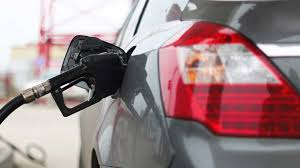

### **E = Ethanol (E85) is making less CO2 then the other fuels**

Now we are going to produce a new feature named 'size of the car' and we will make it in two different ways:


1.   Log ( Engine Size * Cylinders * Fuel Consumption Comb )
2.   Log ( Engine Size * Cylinders * Fuel Consumption Hwy * Fuel Consumption City )

why we do use a Log?

we want our new feature not to have Linear dependency with our previous features.



In [ ]:
data['size of a car'] = np.round(np.log(data['Engine Size(L)'] * data['Cylinders'] * data['Fuel Consumption Comb (L/100 km)']))
plt.figure(figsize=(20,8))
sns.barplot(x = "size of a car",y="CO2 Emissions(g/km)",data = data,
            edgecolor=sns.color_palette("bright", 6))

In [ ]:
data['size of a car2'] = np.round(np.log(data['Engine Size(L)'] * data['Cylinders'] * data['Fuel Consumption Hwy (L/100 km)']*data['Fuel Consumption City (L/100 km)']))
plt.figure(figsize=(20,8))
sns.barplot(x = "size of a car2",y="CO2 Emissions(g/km)",data = data)

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),cmap="BrBG",annot=True)

Our new feature has a good correlation with our CO2 data

In [ ]:
data.nunique()

We want to make all the columns numerical, So we will perform one-hot-encoding using the get_dummies function of Pandas.

In [ ]:
data_with_dummis = data.copy()
data_to_dummis = ['Make','Vehicle Class','Cylinders','Transmission','Fuel Type']
perfix_for_data = ['Make','Cls','Cyl','Trans','F']
for col, per in zip(data_to_dummis, perfix_for_data):
  dummi = pd.get_dummies(data_with_dummis[col], prefix=per, drop_first=True)
  data_with_dummis = data_with_dummis.join(dummi)
    
labels = data_with_dummis['CO2 Emissions(g/km)']

data_to_drop = data_to_dummis+['Model', 'CO2 Emissions(g/km)']

data_to_drop

In [ ]:
final_data = data_with_dummis.drop(data_to_drop, axis=1)
final_data.head()

Now that we are done with the preprocessing stage, we can try different models and compare their results.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_data, labels, test_size= 0.3, random_state=42)

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test,y_test)

In [ ]:
rf = RandomForestRegressor().fit(X_train, y_train)
rf.score(X_test,y_test)

In [ ]:
kn = KNeighborsRegressor().fit(X_train, y_train)
kn.score(X_test,y_test)

In [ ]:
#tuned_parameters = {'weights':['uniform', 'distance'],
                    #'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    #'leaf_size':[10,20,30]}
#n_folds = 5

#knn =  GridSearchCV( KNeighborsRegressor(), tuned_parameters, cv=n_folds, refit=False)
#knn.fit(X_train, y_train)
#knn.best_score_#0.9886276223291075
#knn.best_params_ #{'algorithm': 'brute', 'leaf_size': 10, 'weights': 'distance'}

In [ ]:
kn = KNeighborsRegressor(algorithm= 'brute', leaf_size= 10, weights= 'distance').fit(X_train, y_train)
kn.score(X_test,y_test)

The best model from the ones we tested is the **Random Forest Regressor**, but not by far.  The models can be examined more to find better hyperparameters which can improve results even more.